In [1]:
import os
import random
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

def load_images(image_folder):
    images = []
    for image_file in sorted(os.listdir(image_folder)):
        if image_file.endswith('.jpg') or image_file.endswith('.jpeg') or image_file.endswith('.png'):
            image_path = os.path.join(image_folder, image_file)
            image = Image.open(image_path).convert('L')
            image = image.resize((256, 256))  # Resize images to a fixed size
            image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
            images.append(image)
    return np.array(images)

def create_dataset(new_downloaded_folder, new_cleaned_folder):
    downloaded_images = load_images(new_downloaded_folder)
    cleaned_images = load_images(new_cleaned_folder)
    return train_test_split(downloaded_images, cleaned_images, test_size=0.2, random_state=42)

new_downloaded_folder = './new_downloaded_images'
new_cleaned_folder = './new_cleaned_images'

X_train, X_test, y_train, y_test = create_dataset(new_downloaded_folder, new_cleaned_folder)
# Reshape data to add channel dimension
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

2024-07-23 12:54:12.291072: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 12:54:12.304030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 12:54:12.321649: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 12:54:12.325816: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 12:54:12.337132: I tensorflow/core/platform/cpu_feature_guar

In [19]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    return bce + 0.01 * mse

def unet_model(input_size=(256, 256, 1)):
    inputs = tf.keras.Input(input_size)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv5))
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2D(256, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2D(128, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2D(64, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs, conv9)
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=combined_loss, metrics=['accuracy'])
    return model

model = unet_model()

In [32]:
# Train the U-Net model
history = model.fit(X_train, y_train, epochs=20, batch_size=1, validation_split=0.1)

Epoch 1/20
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - accuracy: 0.9887 - loss: 0.0084 - val_accuracy: 0.9845 - val_loss: 0.0393
Epoch 2/20
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - accuracy: 0.9886 - loss: 0.0083 - val_accuracy: 0.9834 - val_loss: 0.0365
Epoch 3/20
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - accuracy: 0.9885 - loss: 0.0085 - val_accuracy: 0.9842 - val_loss: 0.0472
Epoch 4/20
2055/2347 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9885 - loss: 0.0083

KeyboardInterrupt: 

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9859 - loss: 0.0221
Test Loss: 0.023626936599612236
Test Accuracy: 0.9854493737220764
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


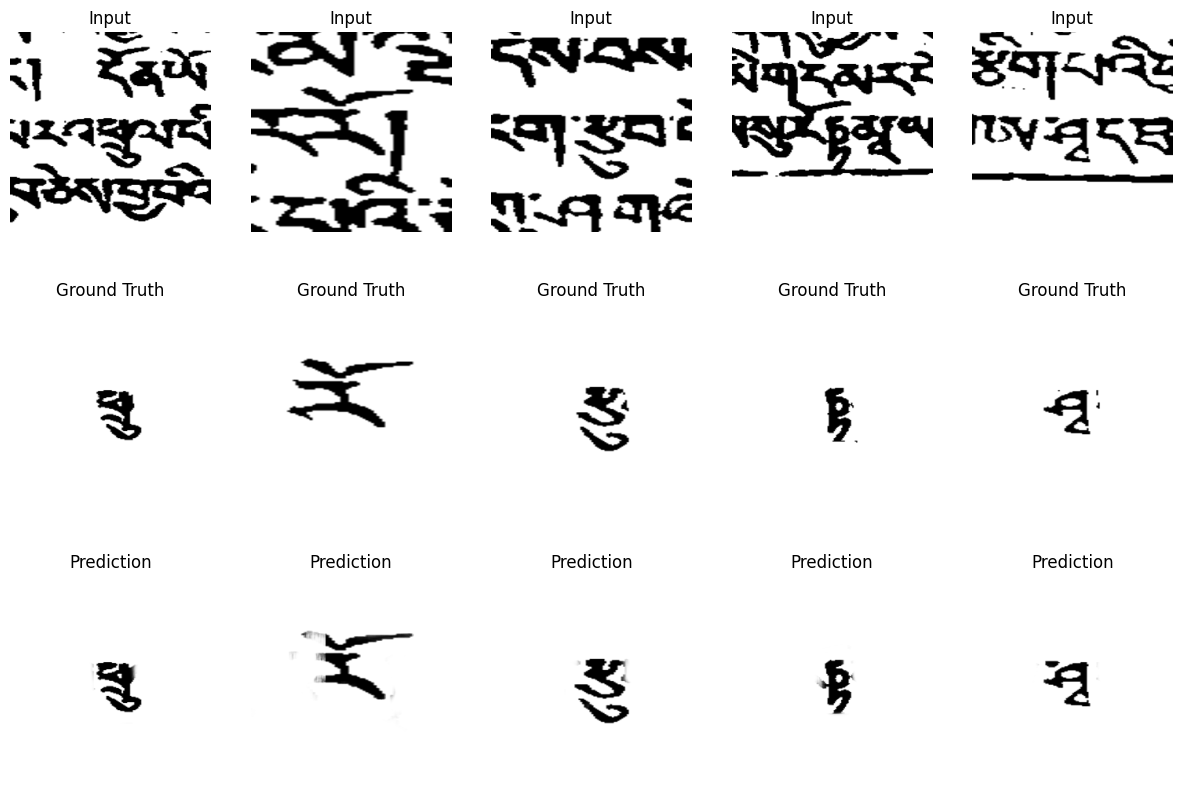

In [35]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
import matplotlib.pyplot as plt

# Display some test results
def display_sample_predictions(model, X_test, y_test):
    predictions = model.predict(X_test)
    n_samples = 5
    plt.figure(figsize=(15, 10))
    for i in range(n_samples):
        idx = random.randint(0, len(X_test) - 1)
        plt.subplot(3, n_samples, i + 1)
        plt.title("Input")
        plt.imshow(X_test[idx].squeeze(), cmap='gray')
        plt.axis('off')
        plt.subplot(3, n_samples, i + n_samples + 1)
        plt.title("Ground Truth")
        plt.imshow(y_test[idx].squeeze(), cmap='gray')
        plt.axis('off')
        plt.subplot(3, n_samples, i + 2 * n_samples + 1)
        plt.title("Prediction")
        plt.imshow(predictions[idx].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

display_sample_predictions(model, X_test, y_test)